In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
adata = sc.read_h5ad('/Users/koush/Projects/SpaceOracle/data/slidetags/snrna_human_tonsil.h5ad')
adata

AnnData object with n_obs × n_vars = 5778 × 3163
    obs: 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'cell_type_int'
    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'spatial'
    layers: 'normalized_count'

In [4]:
import sys
sys.path.append('/Users/koush/Projects/SpaceOracle/src/')

In [6]:
import celloracle as co

%matplotlib inline
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams['figure.dpi'] = 180

In [7]:
%%time

sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)

CPU times: user 1min 39s, sys: 5.79 s, total: 1min 45s
Wall time: 15.2 s


In [8]:
%%time

sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_diffmap')

CPU times: user 1min 9s, sys: 1.33 s, total: 1min 11s
Wall time: 7.05 s


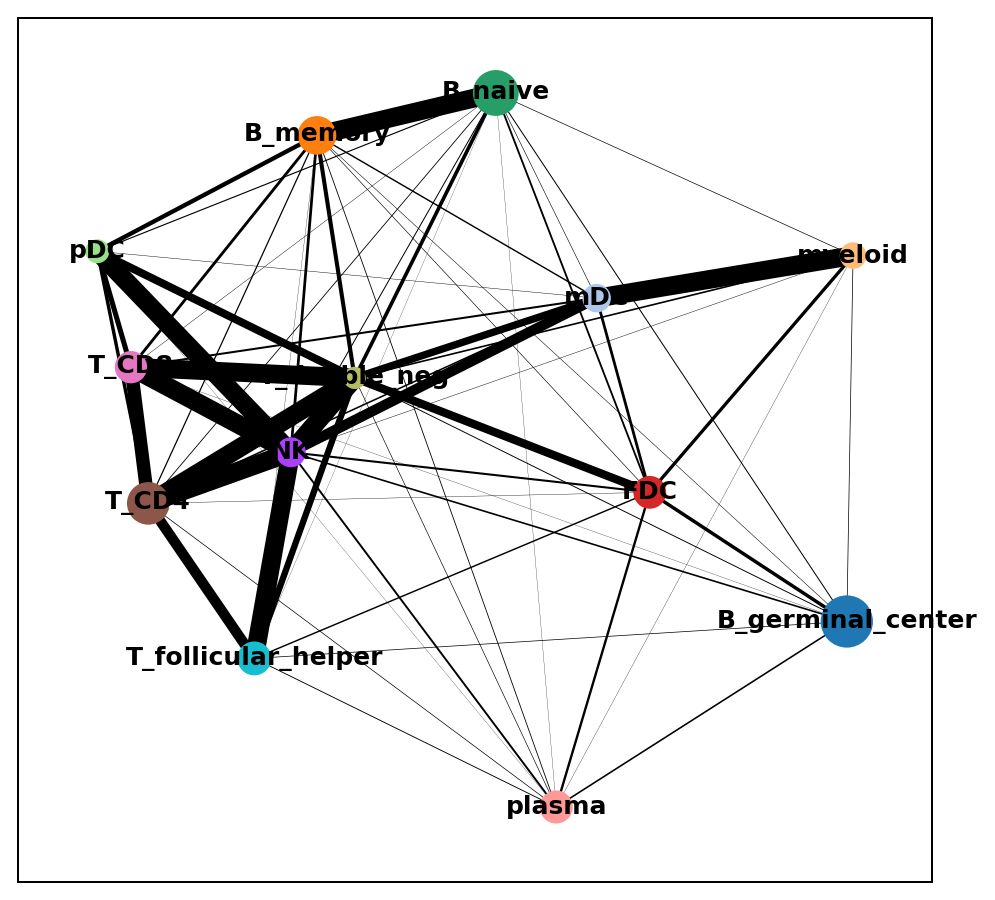

CPU times: user 862 ms, sys: 507 ms, total: 1.37 s
Wall time: 149 ms


In [9]:
%%time

sc.tl.paga(adata, groups='cell_type')
plt.rcParams["figure.figsize"] = [6, 6]
sc.pl.paga(adata)

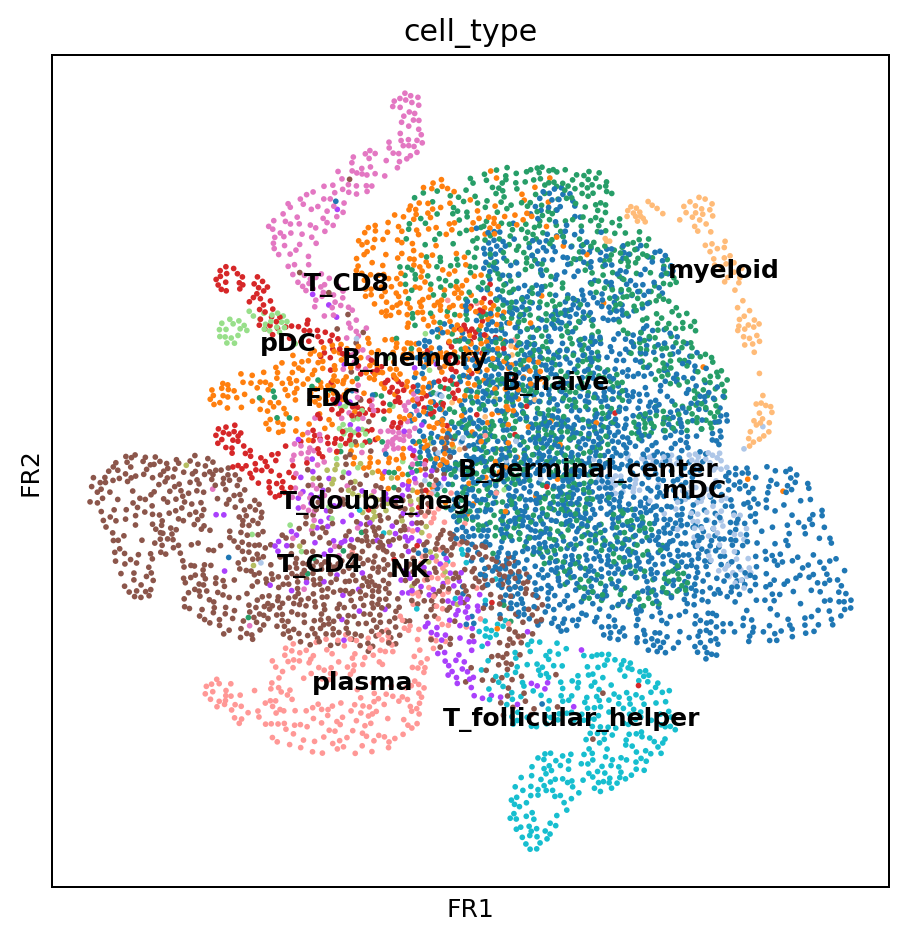

In [10]:
sc.tl.draw_graph(adata, init_pos='paga', random_state=123)
sc.pl.draw_graph(adata, color='cell_type', legend_loc='on data')

In [11]:
adata.layers["raw_count"] = np.exp(adata.X) - 1

In [12]:
oracle = co.Oracle()

adata.X = adata.layers["raw_count"].copy()

oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="cell_type",
    embedding_name="X_draw_graph_fr"
)

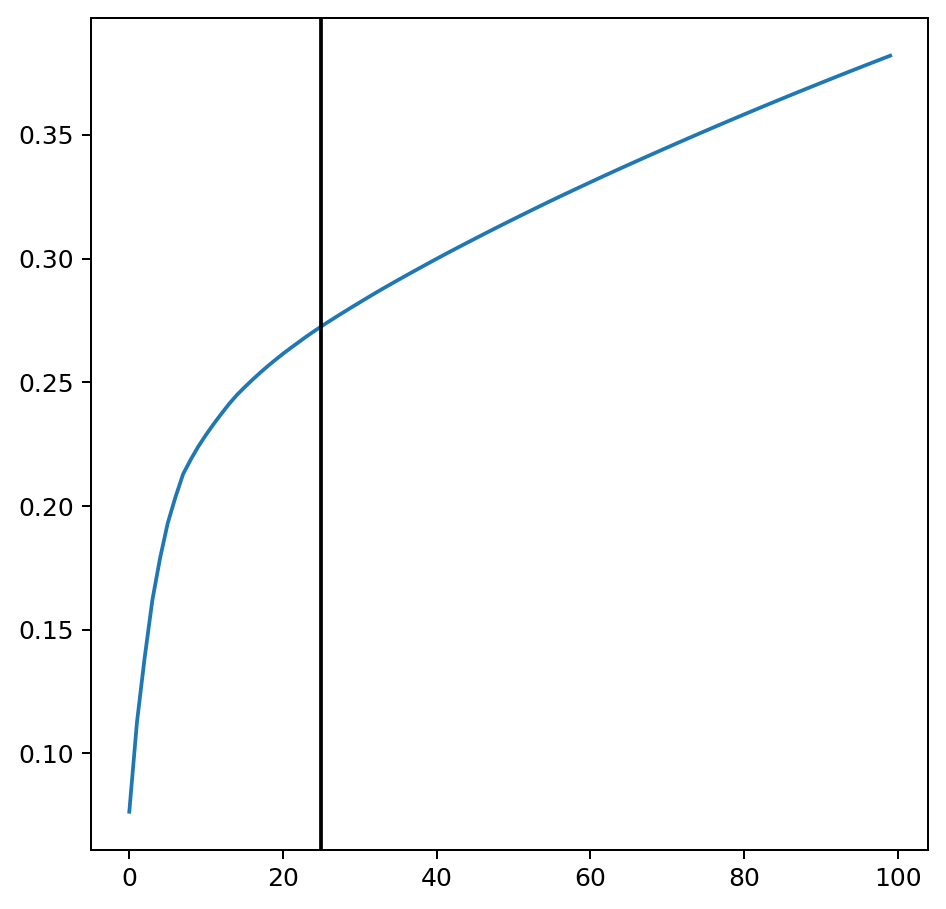

25


In [13]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()

print(n_comps)
n_comps = min(n_comps, 50)

In [14]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

cell number is :5778
Auto-selected k is :144


In [15]:
oracle.knn_imputation(
    n_pca_dims=n_comps, 
    k=k, 
    balanced=True, 
    b_sight=k*8,
    b_maxl=k*4, 
    n_jobs=4
)

In [16]:
base_GRN = co.data.load_human_promoter_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2


In [17]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="cell_type", 
    alpha=10,
    verbose_level=10
)

  0%|          | 0/13 [00:00<?, ?it/s]

Inferring GRN for B_germinal_center...


  0%|          | 0/3057 [00:00<?, ?it/s]

  8%|▊         | 1/13 [01:34<18:49, 94.12s/it]

Inferring GRN for B_memory...


  0%|          | 0/3057 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [03:01<16:34, 90.44s/it]

Inferring GRN for B_naive...


  0%|          | 0/3057 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [04:30<14:55, 89.57s/it]

Inferring GRN for FDC...


  0%|          | 0/3057 [00:00<?, ?it/s]

 31%|███       | 4/13 [05:58<13:20, 88.94s/it]

Inferring GRN for NK...


  0%|          | 0/3057 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [07:29<11:56, 89.54s/it]

Inferring GRN for T_CD4...


  0%|          | 0/3057 [00:00<?, ?it/s]

 46%|████▌     | 6/13 [09:00<10:32, 90.29s/it]

Inferring GRN for T_CD8...


  0%|          | 0/3057 [00:00<?, ?it/s]

 54%|█████▍    | 7/13 [10:31<09:02, 90.35s/it]

Inferring GRN for T_double_neg...


  0%|          | 0/3057 [00:00<?, ?it/s]

 62%|██████▏   | 8/13 [12:01<07:32, 90.41s/it]

Inferring GRN for T_follicular_helper...


  0%|          | 0/3057 [00:00<?, ?it/s]

 69%|██████▉   | 9/13 [13:32<06:01, 90.46s/it]

Inferring GRN for mDC...


  0%|          | 0/3057 [00:00<?, ?it/s]

 77%|███████▋  | 10/13 [15:02<04:31, 90.50s/it]

Inferring GRN for myeloid...


  0%|          | 0/3057 [00:00<?, ?it/s]

 85%|████████▍ | 11/13 [16:33<03:01, 90.52s/it]

Inferring GRN for pDC...


  0%|          | 0/3057 [00:00<?, ?it/s]

 92%|█████████▏| 12/13 [18:04<01:30, 90.63s/it]

Inferring GRN for plasma...


  0%|          | 0/3057 [00:00<?, ?it/s]

100%|██████████| 13/13 [19:35<00:00, 90.40s/it]

CPU times: user 13min 58s, sys: 32.6 s, total: 14min 31s
Wall time: 19min 35s


In [18]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(
    alpha=10, 
    use_cluster_specific_TFdict=True
)

  0%|          | 0/13 [00:00<?, ?it/s]

In [19]:
import pickle

with open('/Users/koush/Projects/SpaceOracle/data/slidetags/tonsil_colinks.pkl', 'wb') as f:
    pickle.dump(links.links_dict, f)

# with open('/Users/koush/Projects/SpaceOracle/data/slidetags/tonsil_celloracle.pkl', 'wb') as f:
#     pickle.dump(oracle, f)

In [20]:
adata

AnnData object with n_obs × n_vars = 5778 × 3163
    obs: 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'cell_type_int'
    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'diffmap_evals', 'paga', 'cell_type_sizes', 'cell_type_colors', 'draw_graph'
    obsm: 'spatial', 'X_pca', 'X_diffmap', 'X_draw_graph_fr'
    varm: 'PCs'
    layers: 'normalized_count', 'raw_count'
    obsp: 'distances', 'connectivities'

In [31]:
{i: k for i, (k,) in enumerate(zip(list(links.links_dict.keys())))}

{0: 'B_germinal_center',
 1: 'B_memory',
 2: 'B_naive',
 3: 'FDC',
 4: 'NK',
 5: 'T_CD4',
 6: 'T_CD8',
 7: 'T_double_neg',
 8: 'T_follicular_helper',
 9: 'mDC',
 10: 'myeloid',
 11: 'pDC',
 12: 'plasma'}

In [34]:
adata = sc.read_h5ad('/Users/koush/Projects/SpaceOracle/data/slidetags/snrna_human_tonsil.h5ad')
adata

AnnData object with n_obs × n_vars = 5778 × 5000
    obs: 'cell_type', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'hvg'
    obsm: 'spatial'
    layers: 'normalized_count'

In [38]:
adata.obs['cell_type_int'] = adata.obs['cell_type'].map(
    {k: i for i, (k,) in enumerate(zip(list(links.links_dict.keys())))})

NAME
AAACCCAAGCGCCTTG-1     5
AAACCCAAGTGGACGT-1    12
AAACCCACAGAAGTGC-1     0
AAACCCAGTCATTGCA-1     2
AAACCCATCATCGCAA-1     1
                      ..
TTTGTTGCAGGGACTA-1     0
TTTGTTGCATTGTAGC-1    12
TTTGTTGGTACCACGC-1     0
TTTGTTGGTCTGTCCT-1     5
TTTGTTGTCATGCGGC-1     5
Name: cell_type, Length: 5778, dtype: category
Categories (13, int64): [0, 1, 2, 3, ..., 9, 10, 11, 12]

In [32]:
{k: i for i, (k,) in enumerate(zip(list(links.links_dict.keys())))}

{'B_germinal_center': 0,
 'B_memory': 1,
 'B_naive': 2,
 'FDC': 3,
 'NK': 4,
 'T_CD4': 5,
 'T_CD8': 6,
 'T_double_neg': 7,
 'T_follicular_helper': 8,
 'mDC': 9,
 'myeloid': 10,
 'pDC': 11,
 'plasma': 12}

In [40]:
adata.write_h5ad('/Users/koush/Projects/SpaceOracle/data/slidetags/snrna_human_tonsil.h5ad')